Importing RcTorch
-----------------

Using pip

In [1]:
#pip install -U rctorch  # '-U' means update to latest version

In [2]:
cd ..

/Users/hayden/Desktop/RcTorch/RcTorch-private


In [3]:
from rctorchprivate import *
#import rctorchprivate
import torch
from rctorchprivate.data import final_figure_plot as phase_plot

from matplotlib.pyplot import cm
from matplotlib import cm

In [4]:
plt.rcParams.update({
    "text.usetex": True})

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

0.5 7.3890560989306495
0.5 2.718281828459045
0.5 0.38674102345450123
0.5 0.36787944117144233
0.5 0.1353352832366127


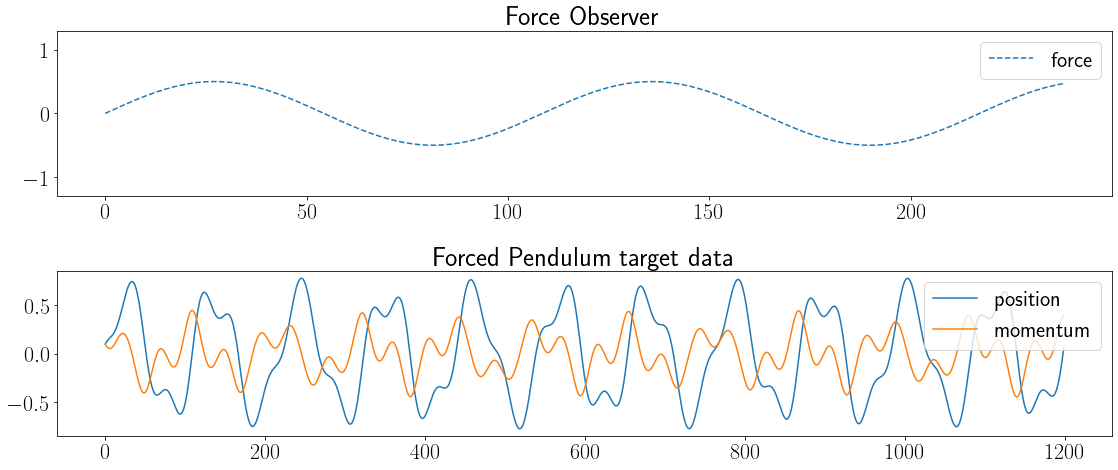

In [5]:
fp_data = data.load("forced_pendulum", train_proportion = 0.2, dt = np.pi/20)

force_train, force_test = fp_data["force"]
target_train, target_test = fp_data["target"]

In [6]:
# hps = {'log_connectivity': 0.4,
#            'spectral_radius': 1.13,
#            'n_nodes': 202,
#            'regularization': 1.69,
#            'leaking_rate': 0.0098085,
#            'bias': 0.49}
hps = {'log_connectivity': 0.4071449746896983,
 'spectral_radius': 1.1329107284545898,
 'n_nodes': 202,
 'regularization': 1.6862021450927922,
 'leaking_rate': 0.009808523580431938,
 'bias': 0.48509588837623596}

In [7]:
plotting_args = {'ylabel_pred' : r'$x$, $p$'}

### Fitting a Pure Prediction RC

mse 2.253
CPU times: user 2.85 s, sys: 1.96 s, total: 4.82 s
Wall time: 16.6 s


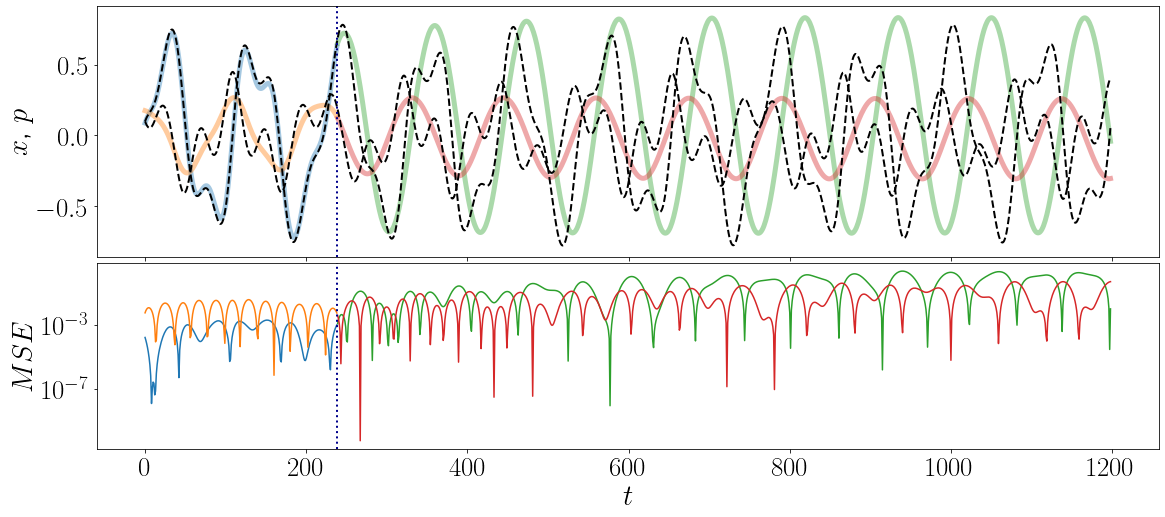

In [8]:
%%time
my_rc = RcNetwork(**hps, random_state = 210, feedback = True)

#fitting the data:
my_rc.fit(y = target_train)

#making our prediction
score, prediction = my_rc.test(y = target_test)
print(f"mse {score:.3f}")
                               
my_rc.combined_plot(**plotting_args)

In [9]:
# hps = {'connectivity': 0.4,
#            'spectral_radius': 1.13,
#            'n_nodes': 202,
#            'regularization': 1.69,
#            'leaking_rate': 0.0098085,
#            'bias': 0.49}

mse 0.229
CPU times: user 37.8 s, sys: 5.26 s, total: 43 s
Wall time: 16 s


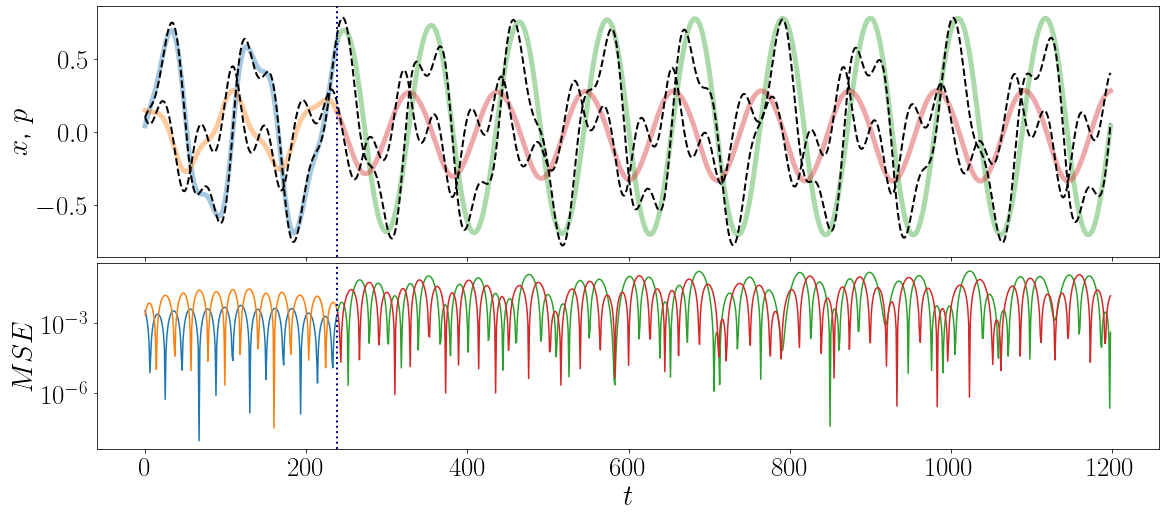

In [10]:
%%time
my_rc2 = RcNetwork(**hps, random_state = 210, feedback = True)

#fitting the data:
my_rc2.fit(X = force_train, y = target_train)

#making our prediction
score, prediction = my_rc2.test(X = force_test, y = target_test)
print(f"mse {score:.3f}")
my_rc2.combined_plot(**plotting_args)

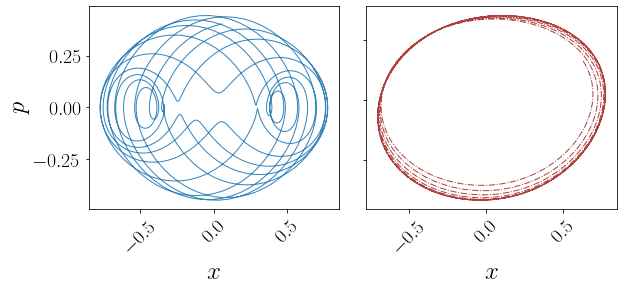

In [11]:
colors = {'color_rc' : "brown", 
          #'color_gt' : "midnightblue", 
          'color_noise':  'peru',
          'linewidth' : 1,
          'alpha' : 0.9,
          'noisy_alpha' : 0.4,
          'noisy_s' : 1,
          'pred_linestyle' : "-.",
          'color_map': cm.afmhot_r}
phase_plot(target_test, None, prediction, 
                  **colors, 
                  label_fontsize = 25,
                  figsize = (9, 4.5)
                 )#, tick_fontsize = 22)

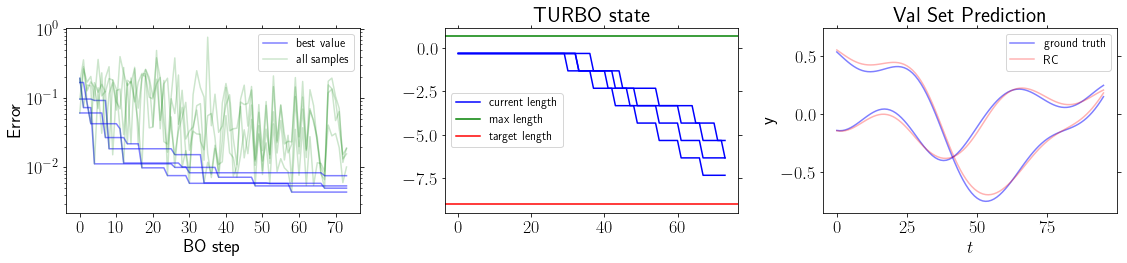

mask [0 1 2 3]
count: 51, self.n_evals 300


/Users/hayden/miniforge3/envs/arm/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/hayden/miniforge3/envs/arm/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/hayden/miniforge3/envs/arm/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/hayden/miniforge3/envs/arm/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitt

NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.

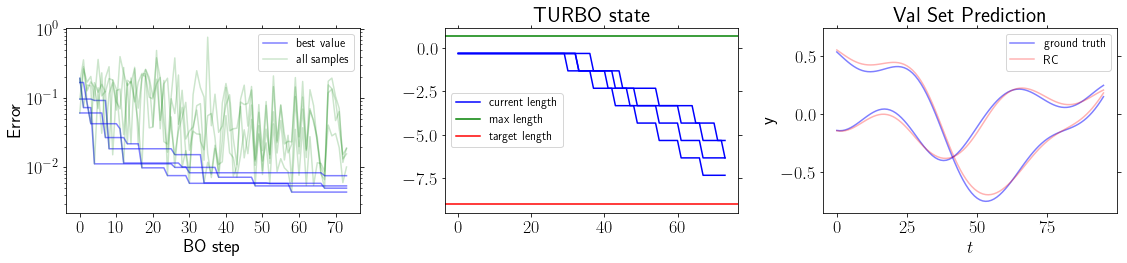

In [12]:
#any hyper parameter can have 'log_' in front of it's name. RcTorch will interpret this properly. 
bounds_dict = {"log_connectivity" : (-2.5, -0.1), 
               "spectral_radius" : (0.1, 3),
               "n_nodes" : (200,202),
               "log_regularization" : (-3, 1),
               "leaking_rate" : (0, 0.2),
               "bias": (-1,1),
               }
rc_specs = { "feedback" : True,
             "reservoir_weight_dist" : "uniform",
             "output_activation" : "tanh",
             "random_seed" : 209}

rc_bo = RcBayesOpt(bounds = bounds_dict, 
                    scoring_method = "nmse",
                    n_jobs = 4,
                    cv_samples = 1,
                    initial_samples= 25,
                    **rc_specs
                    )
opt_hps = rc_bo.optimize( n_trust_regions = 4, 
                                  max_evals = 500,
                                  x = force_train, 
                                  scoring_method = "nmse",
                                  y = target_train)

In [13]:
opt_hps = rc_bo.recover_hps()

In [17]:
opt_hps['regularization'] = 10**opt_hps['log_regularization'] 

mse 0.040
CPU times: user 3.21 s, sys: 3.57 s, total: 6.78 s
Wall time: 8.34 s


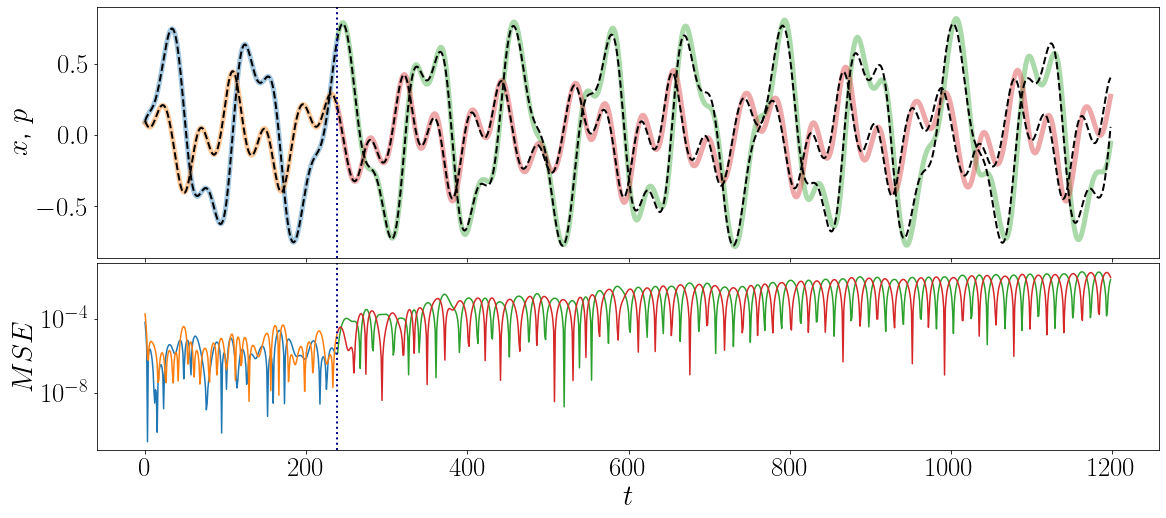

In [18]:
%%time
my_rc2 = RcNetwork(**opt_hps, random_state = 210, feedback = True)

#fitting the data:
my_rc2.fit(X = force_train, y = target_train)

#making our prediction
score, prediction = my_rc2.test(X = force_test, y = target_test)
print(f"mse {score:.3f}")
my_rc2.combined_plot(**plotting_args)

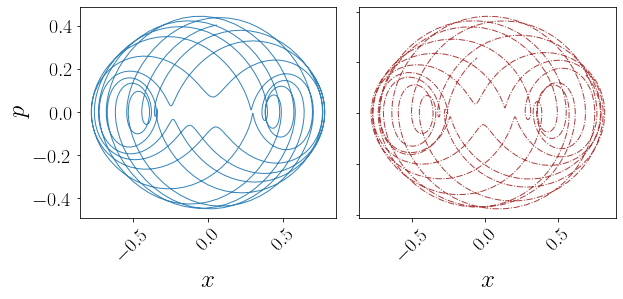

In [19]:
colors = {'color_rc' : "brown", 
          #'color_gt' : "midnightblue", 
          'color_noise':  'peru',
          'linewidth' : 1,
          'alpha' : 0.9,
          'noisy_alpha' : 0.4,
          'noisy_s' : 1,
          'pred_linestyle' : "-.",
          'color_map': cm.afmhot_r}
phase_plot(target_test, None, prediction, 
                  **colors, 
                  label_fontsize = 25,
                  figsize = (9, 4.5)
                 )#, tick_fontsize = 22)